In [1]:
import pandas as pd
import seaborn as sns
from sklearn.naive_bayes import BernoulliNB
import re
import matplotlib.pylab as plt
import numpy as np
from scipy.stats import boxcox
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# 1. Grab and process the raw data

In [2]:
data_path = ('/Users/wesamazaizeh/Downloads/sentiment labelled sentences/imdb_labelled.txt')
imdb_raw = pd.read_csv(data_path, delimiter= '\t', header=None)
imdb_raw.columns = ['text', 'sentiment']

# 2. Feature Engineering

In [3]:
# strip all none-characters
imdb_raw['tidy_text'] = imdb_raw.text.str.replace('[^a-zA-Z#]', ' ')

# are these words included 
keywords = ['bad', 'good', 'best', 'not']

for key in keywords:
    imdb_raw[str(key)] = imdb_raw.tidy_text.str.contains(' ' + str(key) + ' ', case=False)
    
# num of non-characters
imdb_raw['non_alnum'] = imdb_raw.text.str.count(r'[^a-zA-Z0-9 ]')/imdb_raw.text.str.len()

# make target boolean
imdb_raw['sentiment'] = (imdb_raw['sentiment'] == 1)

-24.922884904781217


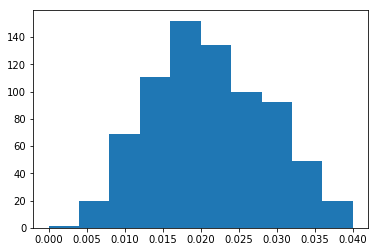

In [4]:
# transforming non-alphanumeric feature
plot_data, lmbda = boxcox(imdb_raw.non_alnum + 1)
plt.hist(plot_data)
print(lmbda)

# assign normal-like data to non-alphanumerical feature
imdb_raw['non_alnum'] = plot_data

Feature standarization (ratio) and transformation reduced its correlation with other features

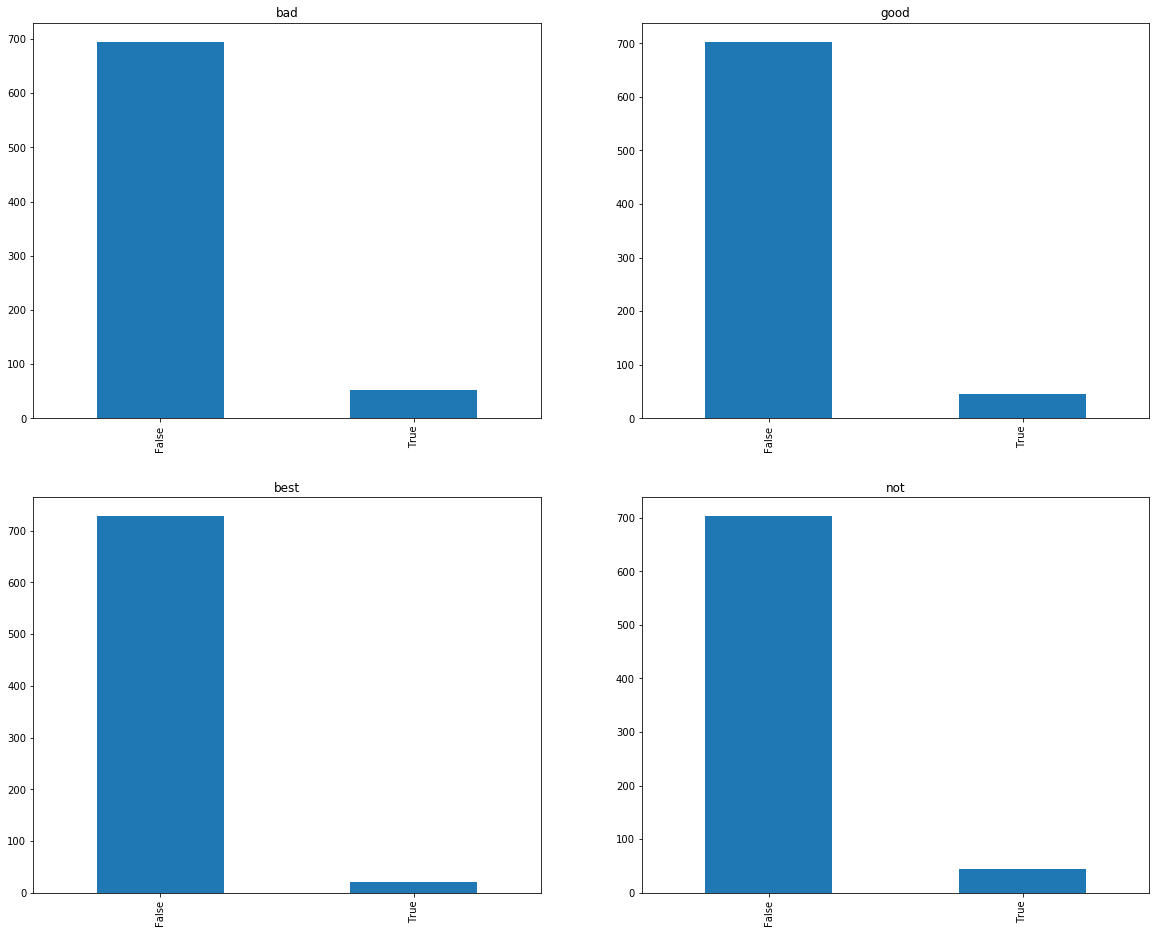

In [5]:
# do the keywords make sense?
cols = keywords

plt.figure(figsize=(20,16))
for i, col in zip(range(1, len(cols)+1) ,cols):
    plt.subplot(2,2,i)
    imdb_raw[col].value_counts().plot(kind='bar', title=col)
    
plt.show()

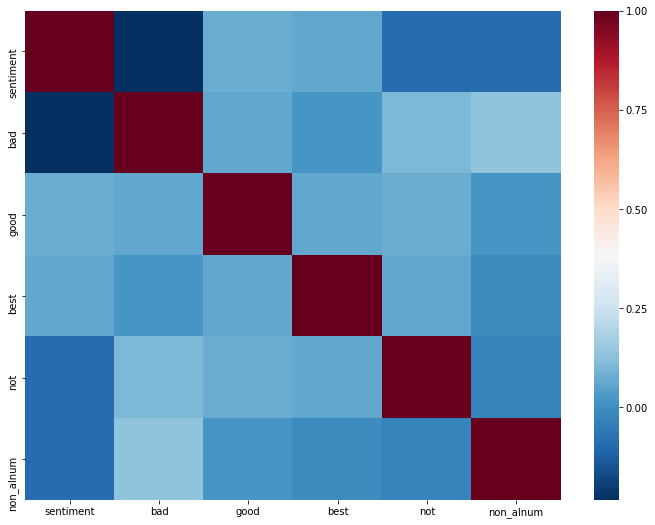

In [6]:
## feature correlation?
plt.figure(figsize=(12,9))
sns.heatmap(imdb_raw.corr(), cmap='RdBu_r')
plt.show()

# 3. Naive Bayes model

In [7]:
# subset data into target and independent variables
data = imdb_raw.loc[:, ~imdb_raw.columns.isin(['sentiment', 'text', 'tidy_text'])]
target = imdb_raw['sentiment']

# instantiate model
bnb = BernoulliNB()

# fit model
bnb.fit(data, target)

# classify
y_pred = bnb.predict(data)

# display results.
print("Number of mislabeled points out of a total {} points : {}".format( data.shape[0], (target != y_pred).sum()))

Number of mislabeled points out of a total 748 points : 309


# 4. Trying to improve model

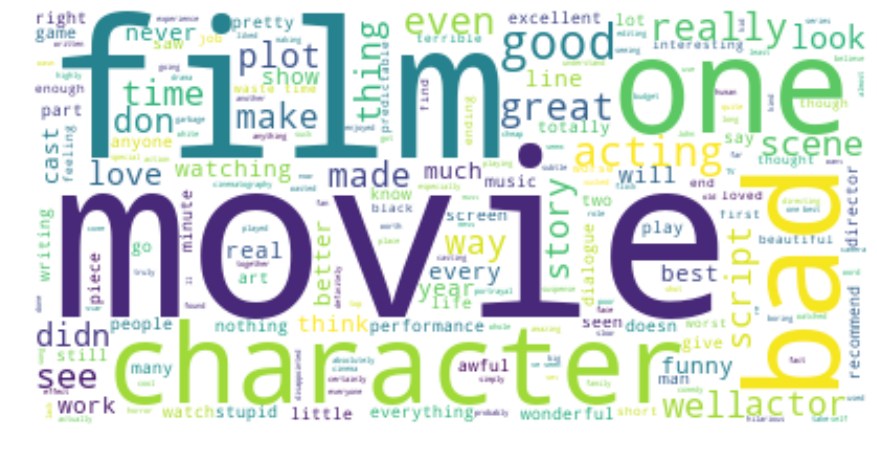

In [8]:
# Generate a word cloud image
wordcloud = WordCloud(background_color="white").generate(" ".join(imdb_raw['tidy_text']))
plt.figure(figsize=(15,10))
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

plt.show()

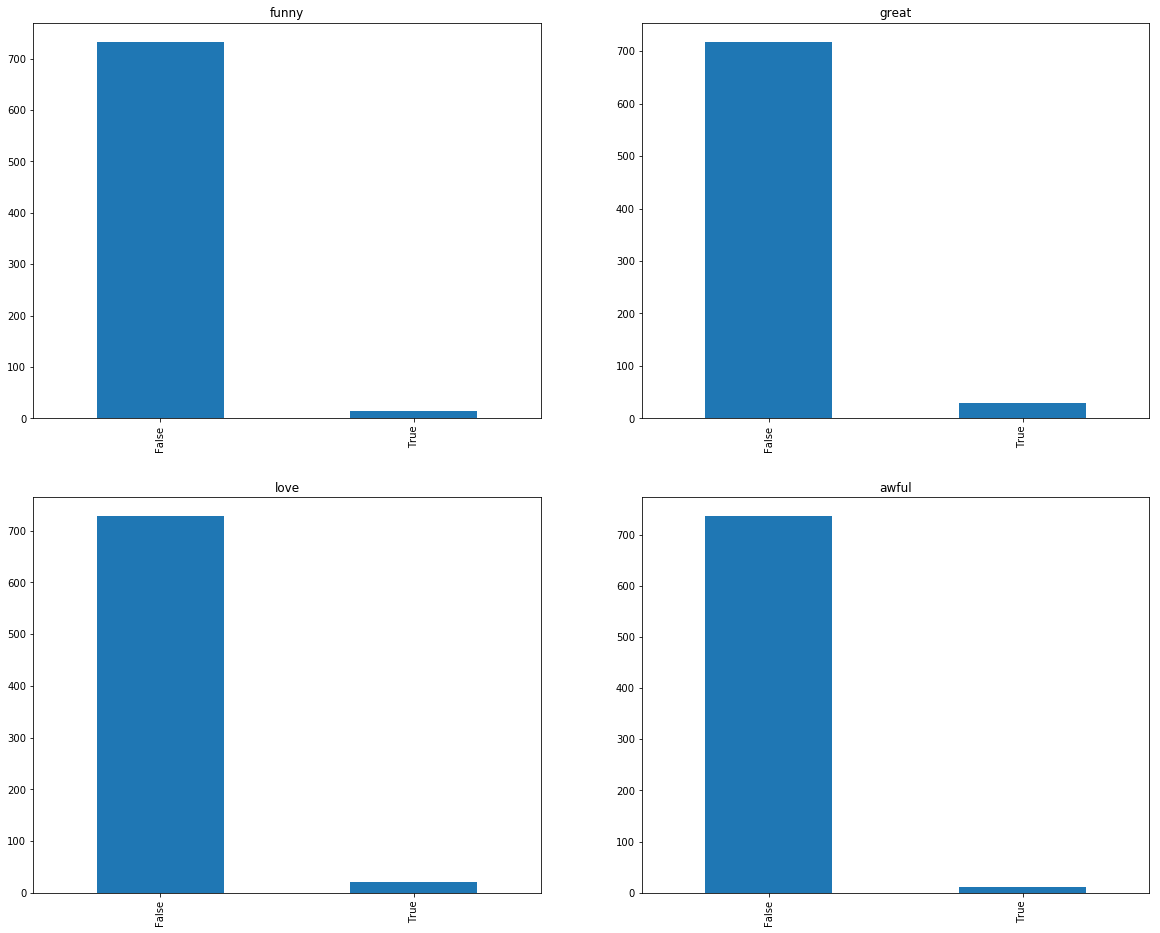

In [9]:
# adding more keywords
keywords2 = ['funny', 'great', 'love', 'awful']

for key in keywords2:
    imdb_raw[str(key)] = imdb_raw.tidy_text.str.contains(' ' + str(key) + ' ', case=False)

# do the keywords make sense?
cols = keywords2

plt.figure(figsize=(20,16))
for i, col in zip(range(1, len(cols)+1) ,cols):
    plt.subplot(2,2,i)
    imdb_raw[col].value_counts().plot(kind='bar', title=col)
    
plt.show()

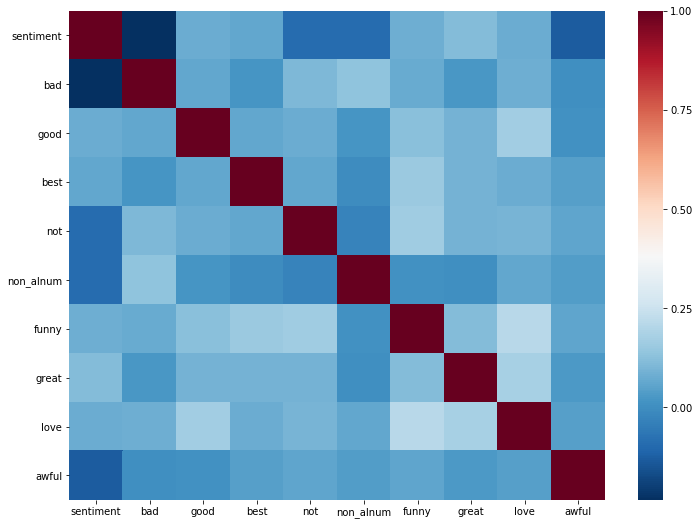

In [10]:
## feature correlation?
plt.figure(figsize=(12,9))
sns.heatmap(imdb_raw.corr(), cmap='RdBu_r')
plt.show()

# 5. More Naive Bayes modeling

In [11]:
# subset data into target and independent variables
data = imdb_raw.loc[:, ~imdb_raw.columns.isin(['sentiment', 'text', 'tidy_text'])]
target = imdb_raw['sentiment']

# instantiate model
bnb = BernoulliNB()

# fit model
bnb.fit(data, target)

# classify
y_pred = bnb.predict(data)

# display results.
print("Number of mislabeled points out of a total {} points : {}".format( data.shape[0], (target != y_pred).sum()))

Number of mislabeled points out of a total 748 points : 294


In [12]:
print('Model sensitivity: {0:.0f}%'.format((1-294/748)*100))

Model sensitivity: 61%


# 6. Even more feature engineering

In [13]:
## import positive and negative words lexicons
data_path = '/Users/wesamazaizeh/Downloads/sentiment labelled sentences/'
pos_words = pd.read_csv(data_path + 'positive-words.txt', skiprows=35, delimiter='\n', header=None)
pos_words = pos_words.rename({0: 'words'}, axis=1) 

neg_words = pd.read_csv(data_path + 'negative-words.txt', skiprows=35, delimiter='\n', header=None)
neg_words = neg_words.rename({0: 'words'}, axis=1) 

# match counting function
def match_counter(target_string, word_list):
    return len(list(filter(lambda x: x in word_list.words.tolist(), target_string.split(' '))))

## How many pos/ neg words are found in each review
imdb_raw['pos_count'] = imdb_raw.apply(lambda row: match_counter(row.tidy_text, pos_words), axis=1)

# neg_exactMatch = re.compile(re.escape(r'\b%s\b' % '\\b|\\b').join(neg_words.words.tolist()), flags=re.IGNORECASE)
imdb_raw['neg_count'] = imdb_raw.apply(lambda row: match_counter(row.tidy_text, neg_words), axis=1)

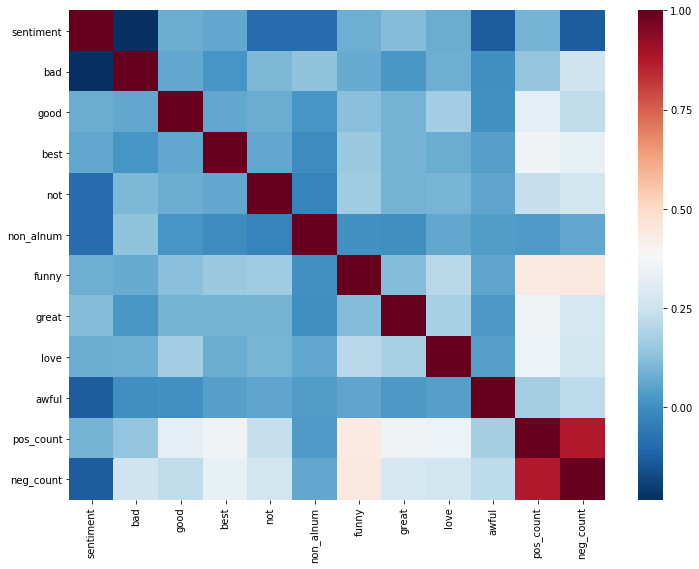

In [14]:
## feature correlation?
plt.figure(figsize=(12,9))
sns.heatmap(imdb_raw.corr(), cmap='RdBu_r')
plt.show()

# 7. More Naive Bayes modeling

In [15]:
# subset data into target and independent variables
data = imdb_raw.loc[:, ~imdb_raw.columns.isin(['sentiment', 'text', 'tidy_text'])]
target = imdb_raw['sentiment']

# instantiate model
bnb = BernoulliNB()

# fit model
bnb.fit(data, target)

# classify
y_pred = bnb.predict(data)

# display results.
print("Number of mislabeled points out of a total {} points : {}".format( data.shape[0], (target != y_pred).sum()))
print('Model sensitivity: {0:.0f}%'.format((1-181/748)*100))

Number of mislabeled points out of a total 748 points : 181
Model sensitivity: 76%


# How would using only pos and neg words compare to this model?

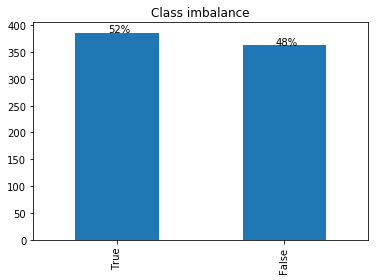

In [16]:
# How does this compare to the class imbalance?

ax = imdb_raw['sentiment'].value_counts().plot(kind='bar', title='Class imbalance')
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.annotate('{:.0%}'.format(height/imdb_raw.shape[0]), (x + 0.2, y + height + 0.2))
plt.show()

In [17]:
confusion_matrix(target, y_pred)

array([[307,  55],
       [126, 260]])

# Model construction conclusion:

Using only 11 simple features the model acheived 76% sensitivity. Most error is false positive, which would end up suggesting things that customers might not like but that's better than missing productions that the customers would like in my opinion.

# 8. Model testing

## 8.1. Holdout group

In [18]:
# subset data into target and independent variables
data = imdb_raw.loc[:, ~imdb_raw.columns.isin(['sentiment', 'text', 'tidy_text'])]
target = imdb_raw['sentiment']

# instantiate model
bnb = BernoulliNB()

# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=20)
print('With 20% Holdout: {:.0f}%'.format(bnb.fit(X_train, y_train).score(X_test, y_test)*100))
print('Testing on Sample: {:.0f}%'.format(bnb.fit(data, target).score(data, target)*100))

With 20% Holdout: 76%
Testing on Sample: 76%


- Consistent. No overfitting.

## 8.2. Cross validation

In [21]:
cross_val_score(bnb, data, target, cv=5)

array([0.72847682, 0.76666667, 0.75838926, 0.73825503, 0.7852349 ])

- some parts of the data seem to vary

In [20]:
imdb_raw.shape

(748, 14)